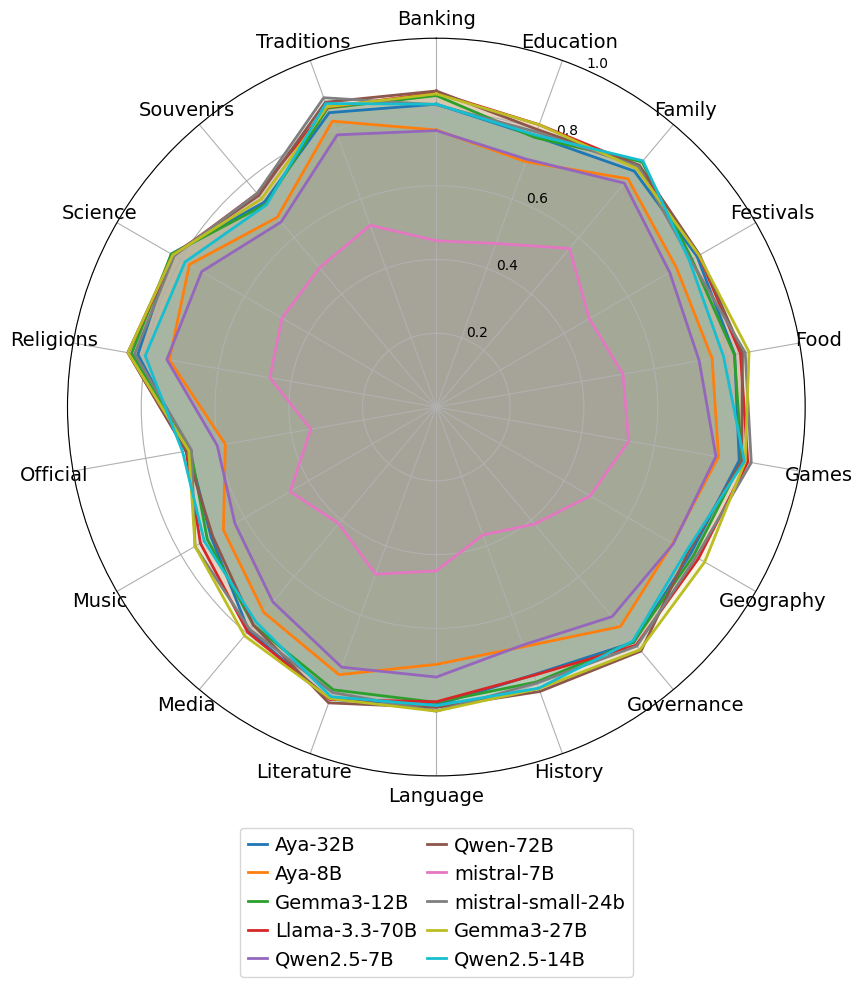

In [ ]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FOLDERS = [
    "../Dataset-commonSence/aya_32B_outputs",
    "../Dataset-commonSence/aya23_8b_eval_outputs",
    "../Dataset-commonSence/gemma3_12b_it_eval_outputs",
    "../Dataset-commonSence/llama33_eval_outputs",
    "../Dataset-commonSence/qwen25_7b_eval_outputs",
    "../Dataset-commonSence/qwen_72B_outputs",
    "../Dataset-commonSence/mistral_7B_eval_outputs",
    "../Dataset-commonSence/mistral_small_24b_eval_outputs",
    "../Dataset-commonSence/gemma3_27b_it_eval_outputs",
    "../Dataset-commonSence/qwen25_14b_eval_outputs"
]

CSV_GLOB = "*_per_item.csv"
CATEGORY_SPLIT = r"[\s_\-]+"


LABEL_MAP = {
    "aya_32B_outputs": "Aya-32B",
    "aya23_8b_eval_outputs": "Aya-8B",
    "gemma3_12b_it_eval_outputs": "Gemma3-12B",
    "llama33_eval_outputs": "Llama-3.3-70B",
    "qwen25_7b_eval_outputs": "Qwen2.5-7B",
    "qwen_72B_outputs": "Qwen-72B",
    "mistral_eval_outputs": "Mistral-7B",
    "mistral_small_24b_eval_outputs-edited": "Mistral-24B",
    "gemma3_27b_it_eval_outputs": "Gemma3-27B",
    "qwen25_14b_eval_outputs": "Qwen2.5-14B",
}

def pretty_label(folder_path: str) -> str:
    base = os.path.basename(os.path.abspath(folder_path))
    if base in LABEL_MAP:
        return LABEL_MAP[base]
    # fallback: clean common suffixes
    s = base
    s = re.sub(r"_eval_outputs.*$", "", s)
    s = re.sub(r"_outputs.*$", "", s)
    s = s.replace("_", "-")
    return s

def first_word_category(filename: str) -> str:
    base = os.path.splitext(os.path.basename(filename))[0]
    parts = re.split(CATEGORY_SPLIT, base.strip())
    cat = parts[0] if parts and parts[0] else base
    return cat.capitalize()


def to_numeric_bool_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_bool_dtype(s):
        return s.astype(float)
    if pd.api.types.is_numeric_dtype(s):
        return (s.astype(float) != 0).astype(float)
    ss = s.astype(str).str.strip().str.lower()
    true_set = {"true", "1", "yes", "y", "correct", "right"}
    false_set = {"false", "0", "no", "n", "incorrect", "wrong"}
    out = pd.Series(np.nan, index=s.index, dtype=float)
    out[ss.isin(true_set)] = 1.0
    out[ss.isin(false_set)] = 0.0
    return out

def infer_accuracy(df: pd.DataFrame) -> float:
    cols = {c.lower(): c for c in df.columns}

    if "accuracy" in cols:
        s = pd.to_numeric(df[cols["accuracy"]], errors="coerce")
        return float(s.mean())

    for key in ["is_correct", "correct"]:
        if key in cols:
            s = to_numeric_bool_series(df[cols[key]])
            return float(s.mean())

    gold_candidates = ["gold_answer", "correct_answer", "gold", "label"]
    pred_candidates = ["pred_answer", "answer", "pred", "prediction", "model_answer"]

    gold_col = next((cols[k] for k in gold_candidates if k in cols), None)
    pred_col = next((cols[k] for k in pred_candidates if k in cols), None)

    if gold_col and pred_col:
        g = df[gold_col].astype(str).str.strip()
        p = df[pred_col].astype(str).str.strip()
        return float((g == p).mean())

    return float("nan")


folder_to_cat_acc = {}
all_categories = set()

for folder in FOLDERS:
    folder_abs = os.path.abspath(folder)
    files = sorted(glob.glob(os.path.join(folder_abs, CSV_GLOB)))
    if not files:
        folder_to_cat_acc[folder_abs] = {}
        continue

    cat_vals = {}
    for fp in files:
        try:
            df = pd.read_csv(fp)
        except Exception:
            continue

        acc = infer_accuracy(df)
        cat = first_word_category(fp)
        if np.isnan(acc):
            continue
        cat_vals.setdefault(cat, []).append(acc)

    cat_avg = {cat: float(np.mean(v)) for cat, v in cat_vals.items() if len(v) > 0}
    folder_to_cat_acc[folder_abs] = cat_avg
    all_categories.update(cat_avg.keys())

categories = sorted(all_categories)
if not categories:
    raise RuntimeError("File not found!")

# =========================
# Radar geometry
# =========================
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  

# =========================
# Plot
# =========================
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=14)

ax.set_rlabel_position(24)
ax.set_ylim(0, 1)

cmap = plt.get_cmap("tab10")

for i, folder in enumerate(FOLDERS):
    f = os.path.abspath(folder)
    cat_avg = folder_to_cat_acc.get(f, {})

    values = [cat_avg.get(cat, np.nan) for cat in categories]
    values = [0.0 if np.isnan(x) else float(x) for x in values]
    values += values[:1] 

    color = cmap(i % 30)
    ax.plot(
        angles, values,
        linewidth=2,
        label=pretty_label(f),
        color=color
    )
    ax.fill(angles, values, alpha=0.12, color=color)


ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.07),  
    ncol=2,                       
    fontsize=14,
    handlelength=1,
    columnspacing=0.5,
    handletextpad=0.4,
    borderaxespad=0.0,
)

plt.tight_layout()
plt.savefig(
    "Reasoing-Acc-categorywise.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [ ]:
import os, glob, re
import numpy as np
import pandas as pd

# =========================
# CONFIG
# =========================
FOLDERS = [
    "../Dataset-commonSence/aya_32B_outputs",
    "../Dataset-commonSence/aya23_8b_eval_outputs",
    "../Dataset-commonSence/gemma3_12b_it_eval_outputs",
    "../Dataset-commonSence/llama33_eval_outputs",
    "../Dataset-commonSence/qwen25_7b_eval_outputs",
    "../Dataset-commonSence/qwen_72B_outputs",
    "../Dataset-commonSence/mistral_7B_eval_outputs",
    "../Dataset-commonSence/mistral_small_24b_eval_outputs",
    "../Dataset-commonSence/gemma3_27b_it_eval_outputs",
    "../Dataset-commonSence/qwen25_14b_eval_outputs"
]
CSV_GLOB = "*_per_item.csv"
CATEGORY_SPLIT = r"[\s_\-]+"


OUT_DIR = "/home/llm-mehrnoush/Dataset-commonSence/ranking_outputs"


RANK_METHOD = "min"     
HIGHER_IS_BETTER = True  


TARGET_MODEL = "Qwen-72B"


LABEL_MAP = {
    "aya_32B_outputs": "Aya-32B",
    "aya23_8b_eval_outputs": "Aya-8B",
    "gemma3_12b_it_eval_outputs": "Gemma3-12B",
    "llama33_eval_outputs": "Llama-3.3-70B",
    "qwen25_7b_eval_outputs": "Qwen2.5-7B",
    "qwen_72B_outputs": "Qwen-72B",
    "mistral_7B_eval_outputs": "Mistral-7B",
    "mistral_small_24b_eval_outputs": "Mistral-24B",
    "gemma3_27b_it_eval_outputs": "Gemma3-27B",
    "qwen25_14b_eval_outputs": "Qwen2.5-14B",
}


pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 220)

# =========================
# Helpers
# =========================
def pretty_label(folder_path: str) -> str:
    base = os.path.basename(os.path.abspath(folder_path))
    return LABEL_MAP.get(base, base)

def first_word_category(filename: str) -> str:
    base = os.path.splitext(os.path.basename(filename))[0]
    parts = re.split(CATEGORY_SPLIT, base.strip())
    cat = parts[0] if parts and parts[0] else base
    return cat.capitalize()

def to_numeric_bool_series(s: pd.Series) -> pd.Series:
    if pd.api.types.is_bool_dtype(s):
        return s.astype(float)
    if pd.api.types.is_numeric_dtype(s):
        return (s.astype(float) != 0).astype(float)
    ss = s.astype(str).str.strip().str.lower()
    true_set = {"true", "1", "yes", "y", "correct", "right"}
    false_set = {"false", "0", "no", "n", "incorrect", "wrong"}
    out = pd.Series(np.nan, index=s.index, dtype=float)
    out[ss.isin(true_set)] = 1.0
    out[ss.isin(false_set)] = 0.0
    return out

def infer_accuracy(df: pd.DataFrame) -> float:
    cols = {c.lower(): c for c in df.columns}

    if "accuracy" in cols:
        s = pd.to_numeric(df[cols["accuracy"]], errors="coerce")
        return float(s.mean())

    for key in ["is_correct", "correct"]:
        if key in cols:
            s = to_numeric_bool_series(df[cols[key]])
            return float(s.mean())

    gold_candidates = ["gold_answer", "correct_answer", "gold", "label"]
    pred_candidates = ["pred_answer", "answer", "pred", "prediction", "model_answer"]

    gold_col = next((cols[k] for k in gold_candidates if k in cols), None)
    pred_col = next((cols[k] for k in pred_candidates if k in cols), None)

    if gold_col and pred_col:
        g = df[gold_col].astype(str).str.strip()
        p = df[pred_col].astype(str).str.strip()
        return float((g == p).mean())

    return float("nan")

# =========================
# 1) Collect per-folder per-category avg acc
# =========================
folder_to_cat_acc = {}
all_categories = set()

for folder in FOLDERS:
    folder_abs = os.path.abspath(folder)
    files = sorted(glob.glob(os.path.join(folder_abs, CSV_GLOB)))

    if not files:
        print(f"[WARN] No CSV files matched in: {folder_abs}")
        folder_to_cat_acc[folder_abs] = {}
        continue

    cat_vals = {}
    for fp in files:
        try:
            df = pd.read_csv(fp)
        except Exception as e:
            print(f"[WARN] Failed to read {fp}: {e}")
            continue

        acc = infer_accuracy(df)
        if np.isnan(acc):
            continue

        cat = first_word_category(fp)
        cat_vals.setdefault(cat, []).append(acc)

    cat_avg = {cat: float(np.mean(v)) for cat, v in cat_vals.items() if len(v) > 0}
    folder_to_cat_acc[folder_abs] = cat_avg
    all_categories.update(cat_avg.keys())

categories = sorted(all_categories)
if not categories:
    raise RuntimeError("No categories found. Check CSV_GLOB and folders.")


model_to_series = {}
for folder_abs, cat_avg in folder_to_cat_acc.items():
    model = pretty_label(folder_abs)
    model_to_series[model] = pd.Series(cat_avg, dtype=float)

score_df = pd.DataFrame(model_to_series).reindex(index=categories).sort_index()
score_df = score_df.round(6)  # keep more precision for saving

print("\n" + "="*120)
print("CATEGORY x MODEL matrix (mean Accuracy)")
print("="*120)
print(score_df.round(4).to_string())


ascending = not HIGHER_IS_BETTER
rank_df = score_df.rank(axis=1, ascending=ascending, method=RANK_METHOD).astype("Int64")

print("\n" + "="*120)
print(f"RANKS per category based on mean Accuracy (1=best) | method={RANK_METHOD}")
print("="*120)
print(rank_df.to_string())

# =========================
#  Extract one model's rank per category
# =========================
if TARGET_MODEL not in rank_df.columns:
    raise ValueError(
        f"TARGET_MODEL='{TARGET_MODEL}' not found.\n"
        f"Available models: {list(rank_df.columns)}"
    )

best_model = score_df.idxmax(axis=1) if HIGHER_IS_BETTER else score_df.idxmin(axis=1)
best_acc = score_df.max(axis=1) if HIGHER_IS_BETTER else score_df.min(axis=1)

out = pd.DataFrame({
    "Acc": score_df[TARGET_MODEL].round(6),
    "Rank": rank_df[TARGET_MODEL],
    "BestModel": best_model,
    "BestAcc": best_acc.round(6),
})
out["GapToBest"] = (out["BestAcc"] - out["Acc"]).round(6) if HIGHER_IS_BETTER else (out["Acc"] - out["BestAcc"]).round(6)

print("\n" + "="*120)
print(f"TARGET MODEL per-category: {TARGET_MODEL}")
print("="*120)
print(out.round(4).to_string())

# =========================
# 5) Save results
# =========================
os.makedirs(OUT_DIR, exist_ok=True)

SCORE_PATH  = os.path.join(OUT_DIR, "acc_score_matrix.csv")
RANK_PATH   = os.path.join(OUT_DIR, "acc_rank_matrix.csv")
TARGET_PATH = os.path.join(OUT_DIR, f"acc_target_{TARGET_MODEL}_per_category.csv")

score_df.to_csv(SCORE_PATH)
rank_df.to_csv(RANK_PATH)
out.to_csv(TARGET_PATH)

# Also save an "ordered" view per category (handy for quick inspection)
ORDERED_PATH = os.path.join(OUT_DIR, "acc_ordered_models_per_category.txt")
with open(ORDERED_PATH, "w", encoding="utf-8") as f:
    for cat in score_df.index:
        row = score_df.loc[cat].dropna()
        if row.empty:
            continue
        ordered = row.sort_values(ascending=ascending)
        line = "  >  ".join([f"{m}:{ordered[m]:.6f}" for m in ordered.index])
        f.write(f"[{cat}] {line}\n")

print("\n[SAVED FILES]")
print(f"  Scores matrix : {SCORE_PATH}")
print(f"  Rank matrix   : {RANK_PATH}")
print(f"  Target model  : {TARGET_PATH}")
print(f"  Ordered view  : {ORDERED_PATH}")

print("\nDONE.")
